In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import CubicSpline
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp

# --- Path Setup ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from config import CONFIG

# --- Directories ---
DERIV_02 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_02_preprocess")
DERIV_03 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_03_resample")
QC_03 = os.path.join(PROJECT_ROOT, CONFIG['qc_dir'], "step_03_resample")

os.makedirs(DERIV_03, exist_ok=True)
os.makedirs(QC_03, exist_ok=True)

print(f"Target FPS: {CONFIG.get('fs_target', 120.0)}")
print("Ready.")

Target FPS: 120.0
Ready.


In [2]:
# Derive filename from config (synchronized with notebooks 01 and 02)
csv_filename = Path(CONFIG['current_csv']).stem
RUN_ID = csv_filename
INPUT_FILE = Path(DERIV_02) / f"{RUN_ID}__preprocessed.parquet"

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Expected file not found: {INPUT_FILE}. Did you run notebook 02?")

print(f"Loading Run: {RUN_ID}")
df_proc = pd.read_parquet(INPUT_FILE)
print(f"Original Shape: {df_proc.shape}")

Loading Run: 734_T1_P2_R1_Take 2025-12-01 02.28.24 PM
Original Shape: (19617, 149)


In [3]:
def resample_timeseries(df, target_fs=120.0):
    """
    Resamples motion data to a strict uniform grid.
    - Positions: Cubic Spline Interpolation (smooths velocity).
    - Rotations: SLERP (Spherical Linear Interpolation).
    """
    # 1. Define New Time Grid
    t_old = df['time_s'].values
    t_start = t_old[0]
    t_end = t_old[-1]
    
    # Generate uniform time points
    dt = 1.0 / target_fs
    t_new = np.arange(t_start, t_end, dt)
    
    print(f"Resampling from {len(t_old)} frames to {len(t_new)} frames (FS={target_fs})")
    
    # Prepare output DataFrame
    df_resampled = pd.DataFrame({'time_s': t_new})
    df_resampled['frame_idx'] = np.arange(len(t_new))
    
    # 2. Identify Columns
    pos_cols = [c for c in df.columns if c.endswith(('__px', '__py', '__pz'))]
    quat_cols = [c for c in df.columns if c.endswith('__qx')]
    segments = [c.replace('__qx', '') for c in quat_cols]
    
    # 3. Resample Positions (Cubic Spline)
    # We process all X, Y, Z columns together for efficiency or per joint
    for col in pos_cols:
        cs = CubicSpline(t_old, df[col].values)
        df_resampled[col] = cs(t_new)
        
    # 4. Resample Rotations (SLERP)
    for seg in segments:
        # Extract Q as (N, 4) array
        qx = df[f"{seg}__qx"].values
        qy = df[f"{seg}__qy"].values
        qz = df[f"{seg}__qz"].values
        qw = df[f"{seg}__qw"].values
        
        # Scipy rotation object
        rotations = R.from_quat(np.column_stack([qx, qy, qz, qw]))
        
        # Create Slerp object
        slerp = Slerp(t_old, rotations)
        
        # Interpolate
        rotations_new = slerp(t_new)
        q_new = rotations_new.as_quat() # Returns (N, 4) -> x, y, z, w
        
        df_resampled[f"{seg}__qx"] = q_new[:, 0]
        df_resampled[f"{seg}__qy"] = q_new[:, 1]
        df_resampled[f"{seg}__qz"] = q_new[:, 2]
        df_resampled[f"{seg}__qw"] = q_new[:, 3]
        
    return df_resampled

# --- Execution ---
TARGET_FPS = CONFIG.get('fs_target', 120.0)
df_resampled = resample_timeseries(df_proc, target_fs=TARGET_FPS)

Resampling from 19617 frames to 19617 frames (FS=120.0)


C:\Users\drorh\AppData\Local\Temp\ipykernel_23200\2209421116.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled[f"{seg}__qw"] = q_new[:, 3]
C:\Users\drorh\AppData\Local\Temp\ipykernel_23200\2209421116.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled[f"{seg}__qx"] = q_new[:, 0]
C:\Users\drorh\AppData\Local\Temp\ipykernel_23200\2209421116.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

In [4]:
# Verify dt consistency
dt = np.diff(df_resampled['time_s'])
mean_dt = np.mean(dt)
std_dt = np.std(dt)
expected_dt = 1.0 / TARGET_FPS

print(f"\n--- Resampling Quality Control ---")
print(f"Expected dt: {expected_dt:.6f}s")
print(f"Actual mean: {mean_dt:.6f}s")
print(f"Actual std:  {std_dt:.9f}s (Should be near 0)")

if std_dt > 1e-6:
    print("⚠️ WARNING: Jitter detected in resampled data!")
else:
    print("✅ SUCCESS: Time grid is perfectly uniform.")


--- Resampling Quality Control ---
Expected dt: 0.008333s
Actual mean: 0.008333s
Actual std:  0.000000000s (Should be near 0)
✅ SUCCESS: Time grid is perfectly uniform.


QC Plot saved to: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\qc\step_03_resample\734_T1_P2_R1_Take 2025-12-01 02.28.24 PM__resample_check.png


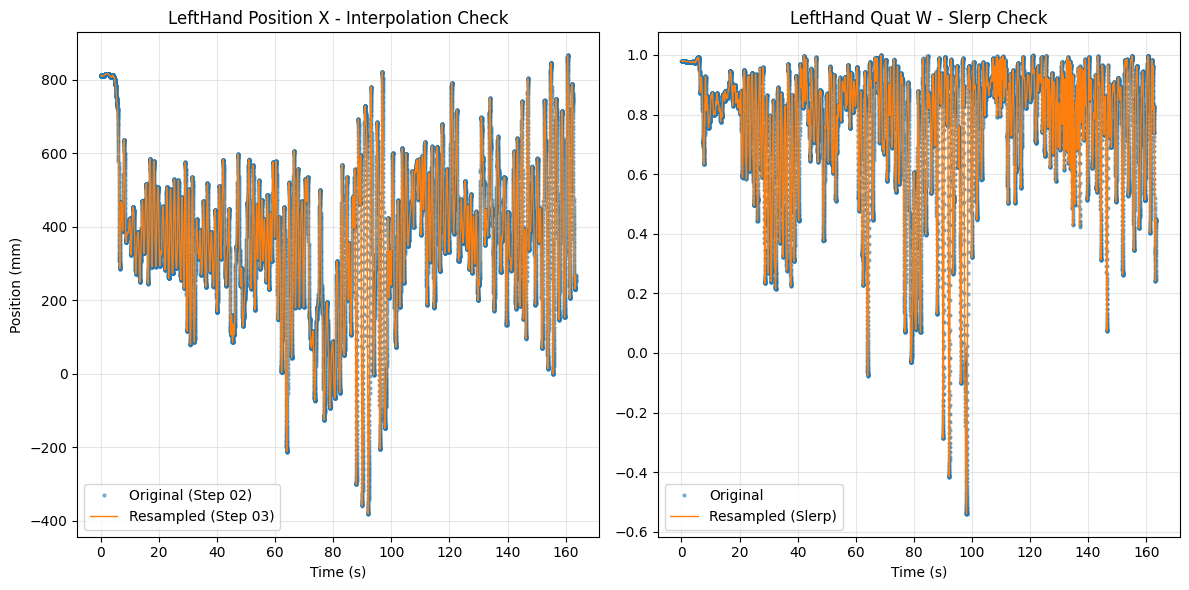

In [5]:
# Plot Original vs Resampled for a sample joint
# Choose a joint with motion (e.g. Head or Hand)
sample_joint = "LeftHand" if "LeftHand__px" in df_resampled.columns else "Head"

plt.figure(figsize=(12, 6))

# Plot Position X
plt.subplot(1, 2, 1)
plt.plot(df_proc['time_s'], df_proc[f'{sample_joint}__px'], 'o', markersize=2, label='Original (Step 02)', alpha=0.5)
plt.plot(df_resampled['time_s'], df_resampled[f'{sample_joint}__px'], '-', label='Resampled (Step 03)', linewidth=1)
plt.title(f'{sample_joint} Position X - Interpolation Check')
plt.xlabel('Time (s)')
plt.ylabel('Position (mm)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Rotation (Quat W)
plt.subplot(1, 2, 2)
plt.plot(df_proc['time_s'], df_proc[f'{sample_joint}__qw'], 'o', markersize=2, label='Original', alpha=0.5)
plt.plot(df_resampled['time_s'], df_resampled[f'{sample_joint}__qw'], '-', label='Resampled (Slerp)', linewidth=1)
plt.title(f'{sample_joint} Quat W - Slerp Check')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
qc_path = os.path.join(QC_03, f"{RUN_ID}__resample_check.png")
plt.savefig(qc_path)
print(f"QC Plot saved to: {qc_path}")
plt.show()

In [6]:
# Save Resampled Data
out_parquet = os.path.join(DERIV_03, f"{RUN_ID}__resampled.parquet")
df_resampled.to_parquet(out_parquet, index=False)

print(f"✅ Saved Resampled Data: {out_parquet}")
print(f"Shape: {df_resampled.shape}")

# Copy the kinematics map from step 02 to step 03 folder (so step 04/05 finds it easily)
import shutil
map_src = os.path.join(DERIV_02, f"{RUN_ID}__kinematics_map.json")
map_dst = os.path.join(DERIV_03, f"{RUN_ID}__kinematics_map.json")

if os.path.exists(map_src):
    shutil.copy(map_src, map_dst)
    print(f"✅ Forwarded kinematics map to: {map_dst}")
else:
    print("⚠️ WARNING: Kinematics map not found in Step 02 output.")



✅ Saved Resampled Data: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_03_resample\734_T1_P2_R1_Take 2025-12-01 02.28.24 PM__resampled.parquet
Shape: (19617, 149)
✅ Forwarded kinematics map to: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_03_resample\734_T1_P2_R1_Take 2025-12-01 02.28.24 PM__kinematics_map.json
